# XGBoost v2 - Binary Classification

**Obiettivo:** Classificazione binaria IncidentGrade (1=TruePositive, 0=FalsePositive/BenignPositive)

**Dataset:** Processed v3 con SmoothedRisk, GeoLoc_freq, frequency encoding

**Metriche:** ROC AUC, Accuracy, Precision, Recall, F1-Score

**Pipeline:**
1. Caricamento dati processed_v3
2. Training XGBoost (binary classification)
3. Valutazione e cross-validation
4. ROC Curve e AUC
5. Feature importance
6. Salvataggio modello in models/xgboost_v2/

## 1. Setup

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score,
    roc_curve,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.model_selection import cross_val_score, StratifiedKFold
import pickle
import os
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('whitegrid')

print("Librerie importate con successo!")

Librerie importate con successo!


## 2. Caricamento Dati

In [22]:
print("Caricamento dataset processed_v3...")

X_train = pd.read_csv('../data/processed_v3_balanced/X_train.csv')
X_test = pd.read_csv('../data/processed_v3_balanced/X_test.csv')
y_train = pd.read_csv('../data/processed_v3_balanced/y_train.csv')['BinaryIncidentGrade']
y_test = pd.read_csv('../data/processed_v3_balanced/y_test.csv')['BinaryIncidentGrade']

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"\nDistribuzione y_train:")
print(y_train.value_counts(normalize=True))
print(f"\nDistribuzione y_test:")
print(y_test.value_counts(normalize=True))

Caricamento dataset processed_v3...
X_train: (348918, 43)
X_test: (149537, 43)

Distribuzione y_train:
BinaryIncidentGrade
0    0.708768
1    0.291232
Name: proportion, dtype: float64

Distribuzione y_test:
BinaryIncidentGrade
0    0.708768
1    0.291232
Name: proportion, dtype: float64


## 3. Training XGBoost (Binary Classification)

In [23]:
print("Training XGBoost per classificazione binaria...\n")

# Calcola scale_pos_weight per gestire imbalance
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count

print(f"Class imbalance: {neg_count} negativi vs {pos_count} positivi")
print(f"scale_pos_weight: {scale_pos_weight:.2f}\n")

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    tree_method='hist',
    n_jobs=-1
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

print("\nTraining completato!")

Training XGBoost per classificazione binaria...

Class imbalance: 247302 negativi vs 101616 positivi
scale_pos_weight: 2.43

[0]	validation_0-auc:0.88534
[1]	validation_0-auc:0.88757
[2]	validation_0-auc:0.90250
[3]	validation_0-auc:0.90668
[4]	validation_0-auc:0.90846
[5]	validation_0-auc:0.90892
[6]	validation_0-auc:0.91127
[7]	validation_0-auc:0.91336
[8]	validation_0-auc:0.91428
[9]	validation_0-auc:0.91465
[10]	validation_0-auc:0.91469
[11]	validation_0-auc:0.91504
[12]	validation_0-auc:0.91593
[13]	validation_0-auc:0.91638
[14]	validation_0-auc:0.91653
[15]	validation_0-auc:0.91677
[16]	validation_0-auc:0.91723
[17]	validation_0-auc:0.91749
[18]	validation_0-auc:0.91768
[19]	validation_0-auc:0.91770
[20]	validation_0-auc:0.91802
[21]	validation_0-auc:0.91804
[22]	validation_0-auc:0.91823
[23]	validation_0-auc:0.91862
[24]	validation_0-auc:0.91884
[25]	validation_0-auc:0.91883
[26]	validation_0-auc:0.91891
[27]	validation_0-auc:0.91896
[28]	validation_0-auc:0.91908
[29]	validation

## 4. Valutazione Performance

In [24]:
# Predizioni
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("=" * 70)
print("PERFORMANCE TEST SET")
print("=" * 70)

print("\nClassification Report:")
print(classification_report(
    y_test, y_pred,
    target_names=['Non-TP (0)', 'TruePositive (1)'],
    digits=4
))

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nACCURACY:          {accuracy:.4f}")
print(f"PRECISION:         {precision:.4f}")
print(f"RECALL:            {recall:.4f}")
print(f"F1-SCORE:          {f1:.4f}")
print(f"ROC AUC:           {roc_auc:.4f} ⭐")

PERFORMANCE TEST SET

Classification Report:
                  precision    recall  f1-score   support

      Non-TP (0)     0.9078    0.9176    0.9127    105987
TruePositive (1)     0.7940    0.7732    0.7835     43550

        accuracy                         0.8755    149537
       macro avg     0.8509    0.8454    0.8481    149537
    weighted avg     0.8747    0.8755    0.8750    149537


ACCURACY:          0.8755
PRECISION:         0.7940
RECALL:            0.7732
F1-SCORE:          0.7835
ROC AUC:           0.9327 ⭐


## 5. Confusion Matrix

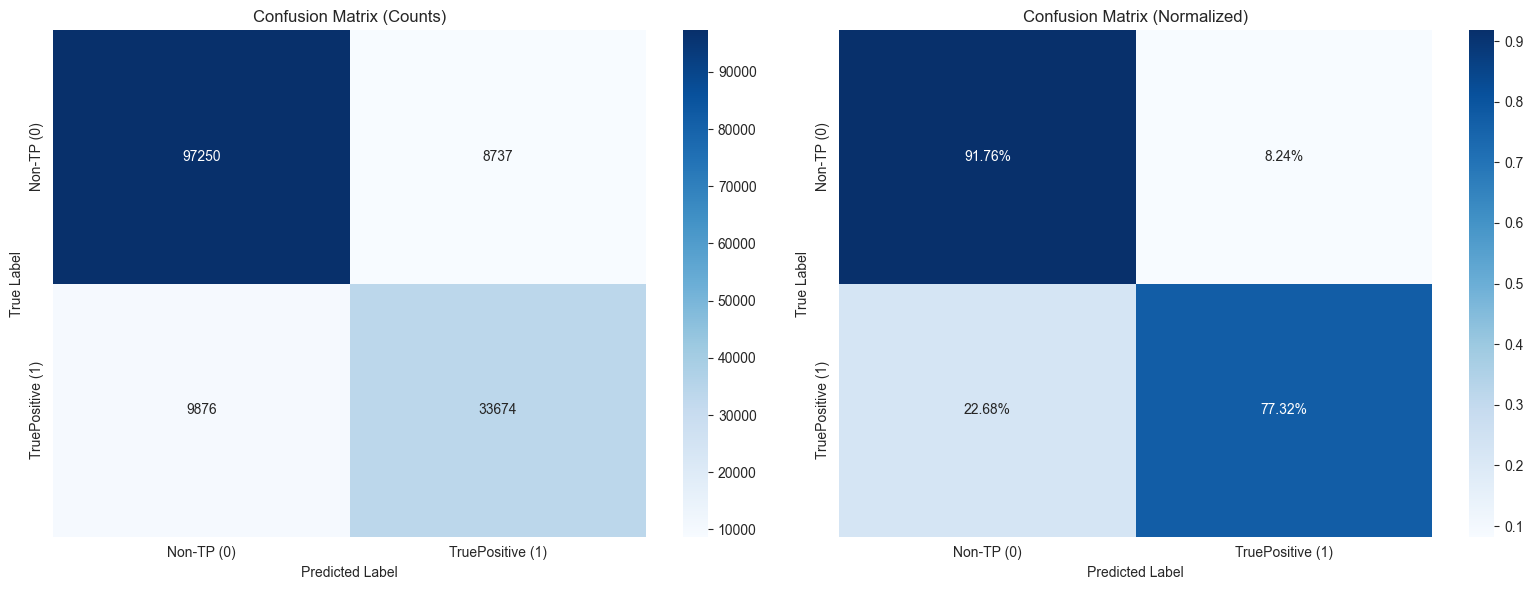

In [25]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-TP (0)', 'TruePositive (1)'],
            yticklabels=['Non-TP (0)', 'TruePositive (1)'],
            ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['Non-TP (0)', 'TruePositive (1)'],
            yticklabels=['Non-TP (0)', 'TruePositive (1)'],
            ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## 6. ROC Curve

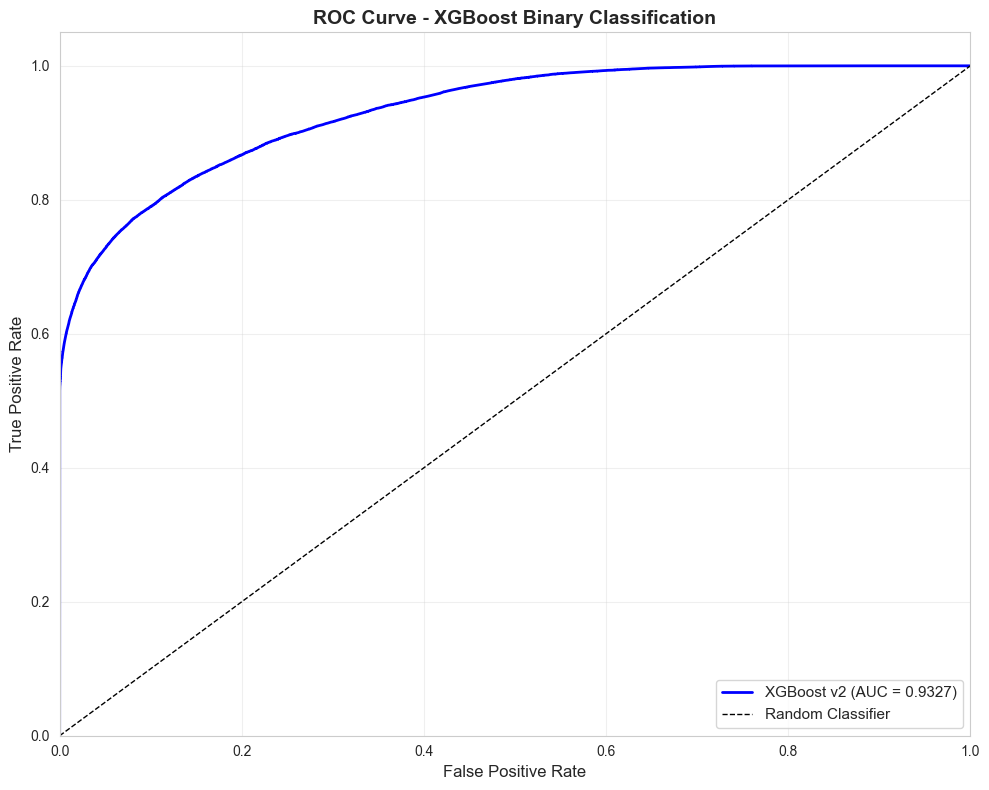


📊 ROC AUC Score: 0.9327


In [26]:
# Calcola ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 8))

plt.plot(fpr, tpr, color='blue', lw=2,
         label=f'XGBoost v2 (AUC = {roc_auc:.4f})')

# Plot diagonal (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - XGBoost Binary Classification', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 ROC AUC Score: {roc_auc:.4f}")

## 7. Cross-Validation

In [27]:
print("Esecuzione 5-Fold Stratified Cross-Validation...\n")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation con ROC AUC
cv_scores = cross_val_score(
    model, X_train, y_train,
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1
)

print(f"Cross-Validation ROC AUC Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\nMedia:  {cv_scores.mean():.4f}")
print(f"Std:    {cv_scores.std():.4f}")

Esecuzione 5-Fold Stratified Cross-Validation...

Cross-Validation ROC AUC Scores:
  Fold 1: 0.9325
  Fold 2: 0.9335
  Fold 3: 0.9319
  Fold 4: 0.9326
  Fold 5: 0.9340

Media:  0.9329
Std:    0.0007


## 8. Feature Importance

In [28]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 30 Features più importanti:")
print(feature_importance.head(30).to_string(index=False))

Top 30 Features più importanti:
                      Feature  Importance
       ResourceType_freq_mean    0.374269
      ActionGrouped_freq_mean    0.282884
     ActionGranular_freq_mean    0.189109
             SmoothedRisk_avg    0.038262
                    T1078_sum    0.030658
              GeoLoc_freq_avg    0.011363
     EvidenceRole_Related_sum    0.007647
        LastVerdict_freq_mean    0.006495
       ThreatFamily_freq_mean    0.005155
              Roles_freq_mean    0.005057
         EntityType_freq_mean    0.004983
   SuspicionLevel_Missing_sum    0.004931
           Category_freq_mean    0.003861
                    T1046_sum    0.002611
             Duration_seconds    0.002412
                 NumEvidences    0.001913
                    NumAlerts    0.001907
                    T1106_sum    0.001900
SuspicionLevel_Suspicious_sum    0.001584
               month_get_mode    0.001479
                IsWeekend_max    0.001453
                    T1568_sum    0.001295
  

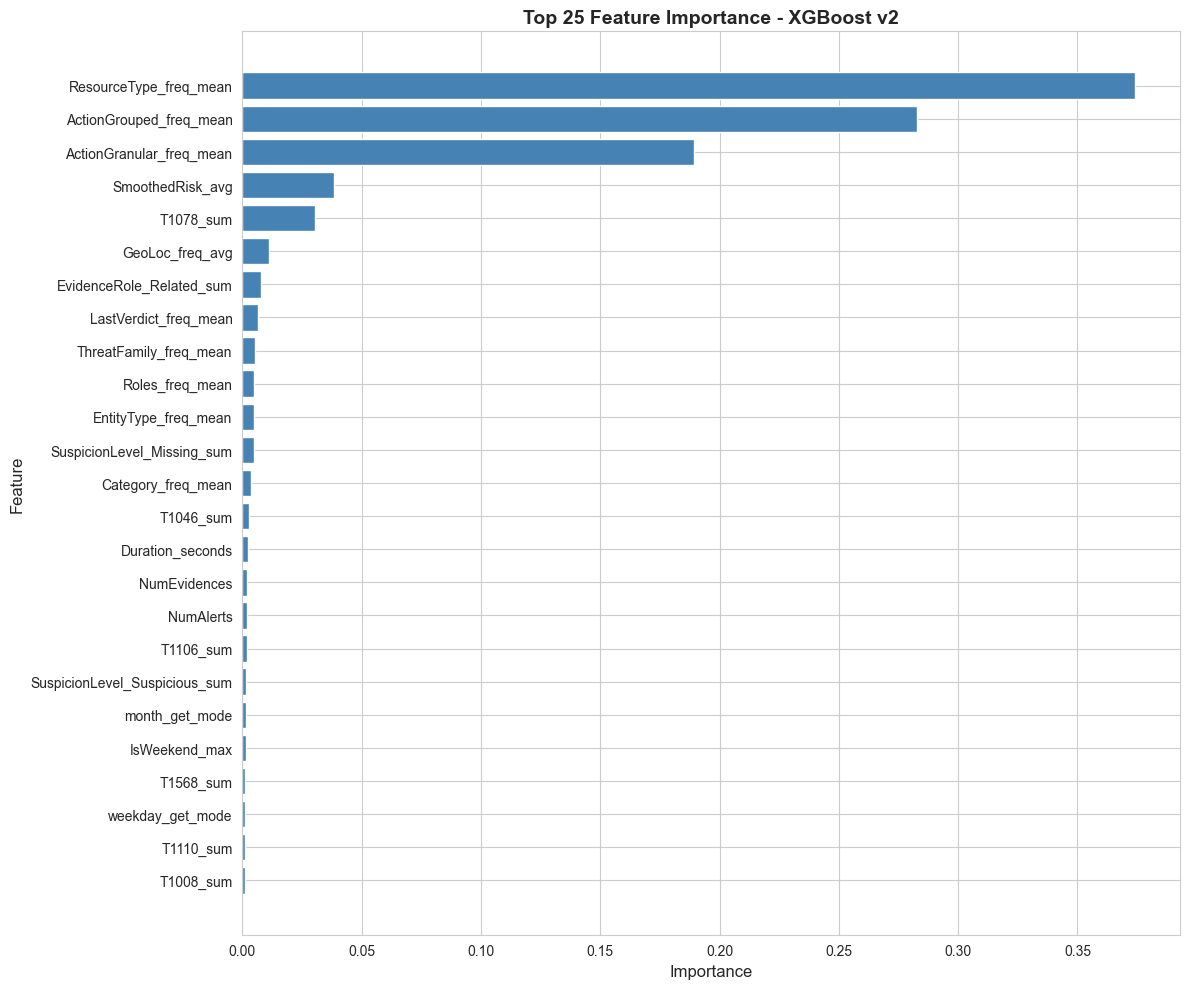

In [29]:
# Plot top features
plt.figure(figsize=(12, 10))
top_n = 25
top_features = feature_importance.head(top_n)

plt.barh(range(top_n), top_features['Importance'], color='steelblue')
plt.yticks(range(top_n), top_features['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title(f'Top {top_n} Feature Importance - XGBoost v2', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 9. Salvataggio Modello

In [30]:
# Crea cartella per XGBoost v2
model_dir = '../models/xgboost_v2'
os.makedirs(model_dir, exist_ok=True)

# Salva modello
model.save_model(f'{model_dir}/model.json')

with open(f'{model_dir}/model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Salva feature importance
feature_importance.to_csv(f'{model_dir}/feature_importance.csv', index=False)

# Salva metriche complete
metrics = {
    'model_name': 'XGBoost_v2_Binary',
    'timestamp': datetime.now().isoformat(),
    'dataset_version': 'processed_v3',
    'target': 'BinaryIncidentGrade (0=Non-TP, 1=TP)',
    'test_accuracy': float(accuracy),
    'test_precision': float(precision),
    'test_recall': float(recall),
    'test_f1_score': float(f1),
    'test_roc_auc': float(roc_auc),
    'cv_roc_auc_mean': float(cv_scores.mean()),
    'cv_roc_auc_std': float(cv_scores.std()),
    'n_features': int(X_train.shape[1]),
    'n_train_samples': int(len(X_train)),
    'n_test_samples': int(len(X_test)),
    'class_distribution_train': {
        'class_0': int((y_train == 0).sum()),
        'class_1': int((y_train == 1).sum())
    },
    'hyperparameters': {
        'objective': 'binary:logistic',
        'max_depth': model.max_depth,
        'learning_rate': float(model.learning_rate),
        'n_estimators': model.n_estimators,
        'subsample': float(model.subsample),
        'colsample_bytree': float(model.colsample_bytree),
        'scale_pos_weight': float(scale_pos_weight)
    },
    'top_10_features': feature_importance.head(10)[['Feature', 'Importance']].to_dict('records')
}

with open(f'{model_dir}/metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"\n{'='*70}")
print(f"Modello salvato in {model_dir}/")
print(f"{'='*70}")
print("  ✓ model.json")
print("  ✓ model.pkl")
print("  ✓ feature_importance.csv")
print("  ✓ metrics.json")
print(f"\n📊 ROC AUC Test: {roc_auc:.4f}")
print(f"📊 ROC AUC CV:   {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Modello salvato in ../models/xgboost_v2/
  ✓ model.json
  ✓ model.pkl
  ✓ feature_importance.csv
  ✓ metrics.json

📊 ROC AUC Test: 0.9327
📊 ROC AUC CV:   0.9329 ± 0.0007


## Summary

**Modello:** XGBoost Binary Classifier  
**Dataset:** processed_v3 (SmoothedRisk, GeoLoc_freq, frequency encoding)  
**Target:** BinaryIncidentGrade (0=FalsePositive/BenignPositive, 1=TruePositive)  

**Features chiave del v3:**
- SmoothedRisk (Bayesian smoothing per AlertTitle)
- GeoLoc_freq (frequenza location)
- Frequency encoding per colonne ad alta cardinalità
- MITRE top 30 techniques

**Metriche principali:**
- ROC AUC (primary metric per binary classification)
- Precision/Recall/F1 per valutare trade-off
- Cross-validation per robustezza